# Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig 
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio

In [3]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [4]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
graph_data = data_processed + "graph_data_nohubs/"
reports_comunidades = "../../../reports/reports_nohubs/analisis_comunidades/"

graph_node_data = pd.read_csv(graph_data+"nohub_graph_node_data.csv")
graph_edge_data = pd.read_csv(graph_data+"nohub_graph_edge_data.csv").rename(columns={"relation":"edge_type"})

disease_attributes = pd.read_csv(graph_data+"nohub_disease_attributes.csv")

node_counts = dict(graph_node_data.node_type.value_counts())
node_counts["total"] = sum(node_counts.values())

edge_counts = dict(graph_edge_data.edge_type.value_counts()/2)
edge_counts["total"] = sum(edge_counts.values())

display(pd.DataFrame.from_dict({"Número de nodos":node_counts}, orient="columns"))
display(pd.DataFrame.from_dict({"Número de enlaces":edge_counts}, orient="columns"))

,Número de nodos
bert_group,1040
complex,421
disease,15039
gene_protein,17322
pathway,2017
total,35839


,Número de enlaces
disease_disease,16433.0
form_complex,1885.0
gda,84014.0
pathway_protein,42643.0
ppi,110051.0
total,255026.0


In [5]:
enfermedades = graph_node_data[(graph_node_data.node_type == "disease")|(graph_node_data.node_type == "bert_group")]

In [6]:
tamaños_infomap = enfermedades.dropna().comunidades_infomap.value_counts()
tamaños_louvain = enfermedades.dropna().comunidades_louvain.value_counts()

Text(0.5, 0, 'Tamaño')

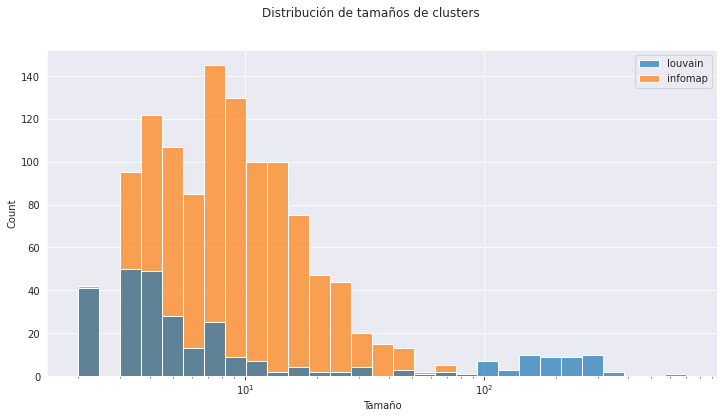

In [7]:
# fig, ax = plt.subplots(1,2,figsize=(16,6))
# fig.suptitle("Distribución de tamaños de clusters")
# ticks = np.logspace(0,tamaños_infomap.max(),10)

# sns.histplot(data=tamaños_infomap, log_scale=True, ax=ax[0])
# ax[0].set_xlabel("Tamaño")
# ax[0].set_title("Infomap")

# sns.histplot(data=tamaños_louvain,log_scale=(False,True), ax=ax[1],bins=np.linspace(2,tamaños_louvain.max(),40))
# ax[1].set_xlabel("Tamaño")
# ax[1].set_title("Louvain")

fig2, ax2 = plt.subplots(figsize=(12,6))
sns.histplot(data=pd.DataFrame({"infomap":tamaños_infomap,"louvain":tamaños_louvain}), log_scale=True,ax=ax2, palette="tab10",multiple="layer",alpha=0.7,hue_order=["louvain","infomap"])
fig2.suptitle("Distribución de tamaños de clusters")
ax2.set_xlabel("Tamaño")

# fig2.savefig(reports_comunidades+"distribucion_tamaños.png", dpi=200)

Métricas de similaridad de conjuntos

In [8]:
# Unión: |, Intersección: &
def jaccard(set1,set2):
    intersection = len(set1&set2)
    union = len(set1|set2)
    return intersection/union

def int_min(set1,set2):
    intersection = len(set1&set2)
    min_set = np.min([len(set1),len(set2)])
    return intersection/min_set

def int_max(set1,set2):
    intersection = len(set1&set2)
    max_set = np.max([len(set1),len(set2)])
    return intersection/max_set

In [9]:
comunidades_infomap = enfermedades.comunidades_infomap.dropna().astype("int").sort_values().unique()
comunidades_louvain = enfermedades.comunidades_louvain.dropna().astype("int").sort_values().unique()

In [10]:
enfermedades

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
1,19599,C0019209,Hepatomegaly,disease,disgenet,NaN,NaN,54.0,0.0,0.0
8,20754,C0036341,Schizophrenia,disease,disgenet,0.0,0.0,883.0,0.0,1.0
16,24165,C0376358,Malignant neoplasm of prostate,disease,disgenet,3.0,2.0,616.0,0.0,6.0
17,18773,C0006142,Malignant neoplasm of breast,disease,disgenet,11.0,3.0,1074.0,0.0,7.0
18,18732,C0005695,Bladder Neoplasm,disease,disgenet,28.0,3.0,140.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...
35834,30820,C3151471,"AMYLOID CARDIOMYOPATHY, TRANSTHYRETIN-RELATED",disease,disgenet,766.0,22.0,0.0,0.0,1.0
35835,30959,C3278148,"BERNARD-SOULIER SYNDROME, TYPE A1",disease,disgenet,1106.0,252.0,0.0,0.0,1.0
35836,33955,C4722518,Triple-Negative Breast Carcinoma,disease,disgenet,17.0,2.0,0.0,0.0,1.0
35837,32968,C4289709,DOCK8 Deficiency,disease,disgenet,127.0,17.0,0.0,0.0,1.0


In [11]:
conjuntos_infomap = {int(comunidad):set(enfermedades.loc[enfermedades.comunidades_infomap == comunidad,"node_index"].values) for comunidad in comunidades_infomap}
conjuntos_louvain = {int(comunidad):set(enfermedades.loc[enfermedades.comunidades_louvain == comunidad,"node_index"].values) for comunidad in comunidades_louvain}

In [12]:
nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

tamaños_louvain = disease_attributes.comunidades_louvain.value_counts()
tamaños_infomap = disease_attributes.comunidades_infomap.value_counts()

infomap_clusters = pd.DataFrame(tamaños_infomap).reset_index().rename(columns={"index":"comunidad","comunidades_infomap":"tamaño"}).astype({"comunidad":"int"})
louvain_clusters = pd.DataFrame(tamaños_louvain).reset_index().rename(columns={"index":"comunidad","comunidades_louvain":"tamaño"}).astype({"comunidad":"int"})

# Comparación entre particiones

In [13]:
matrix_jaccard = {}
matrix_min = {}
matrix_max = {}

for comunidad_infomap,set_infomap in conjuntos_infomap.items():
    partial_jaccard = {}
    partial_min = {}
    partial_max = {}
    for comunidad_louvain, set_louvain in conjuntos_louvain.items():
        coef_jaccard = jaccard(set_infomap,set_louvain)
        coef_min = int_min(set_infomap,set_louvain)
        coef_max = int_max(set_infomap,set_louvain)
        partial_jaccard[comunidad_louvain] = coef_jaccard
        partial_min[comunidad_louvain] = coef_min
        partial_max[comunidad_louvain] = coef_max
    matrix_jaccard[comunidad_infomap] = partial_jaccard
    matrix_min[comunidad_infomap] = partial_min
    matrix_max[comunidad_infomap] = partial_max

In [14]:
df_jaccard = pd.DataFrame(matrix_jaccard)
df_min = pd.DataFrame(matrix_min)
df_max = pd.DataFrame(matrix_max)

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

/tmp/ipykernel_54758/3373611155.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  infomap_corte = infomap_clusters.sort_values(by="tamaño", ascending=False)[infomap_clusters.tamaño > n].comunidad.values
/tmp/ipykernel_54758/3373611155.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  louvain_corte = louvain_clusters.sort_values(by="tamaño", ascending=False)[louvain_clusters.tamaño > n].comunidad.values
/tmp/ipykernel_54758/3373611155.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im2, ax=ax2,fraction=0.046, pad=0.04, cax=cax2)


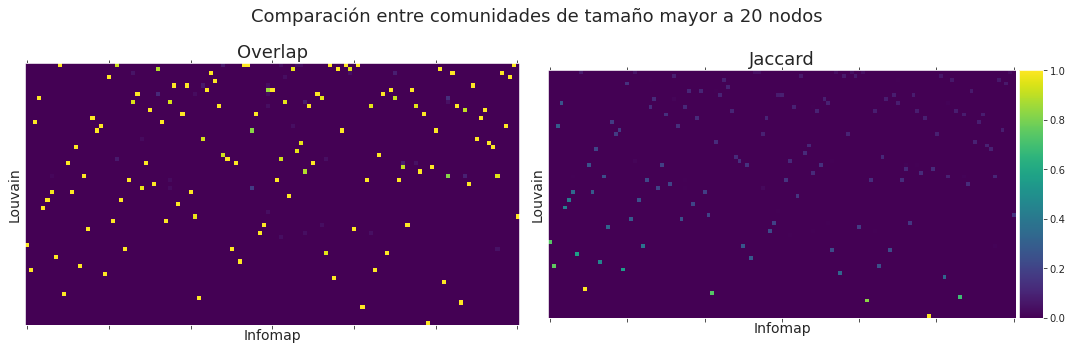

In [133]:
n = 20

infomap_corte = infomap_clusters.sort_values(by="tamaño", ascending=False)[infomap_clusters.tamaño > n].comunidad.values
louvain_corte = louvain_clusters.sort_values(by="tamaño", ascending=False)[louvain_clusters.tamaño > n].comunidad.values

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5), sharey=True)
fig.suptitle(f"Comparación entre comunidades de tamaño mayor a {n} nodos", fontsize=18)

jaccard_mat = df_jaccard.loc[louvain_corte,infomap_corte]
min_mat = df_min.loc[louvain_corte,infomap_corte]
max_mat = df_max.loc[louvain_corte, infomap_corte]

cmap = "viridis"

im = ax1.matshow(min_mat,
                cmap=cmap)
ax1.set_title("Overlap", fontsize=18)
# cbar = fig.colorbar(im, ax=ax1)
ax1.tick_params(labelbottom=False, labelleft=False,labeltop=False)
ax1.set_xlabel("Infomap", fontsize=14)
ax1.set_ylabel("Louvain", fontsize=14)
ax1.grid(False)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# cbar = fig.colorbar(im, ax=ax2,fraction=0.046, pad=0.04, cax=cax)


im2 = ax2.matshow(jaccard_mat,
                cmap=cmap)
ax2.set_title('Jaccard', fontsize=18)
# cbar = fig.colorbar(im2, ax=ax2)
ax2.tick_params(labelbottom=False, labelleft=False,labeltop=False)
ax2.set_xlabel("Infomap", fontsize=14)
ax2.set_ylabel("Louvain", fontsize=14)
ax2.grid(False)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im2, ax=ax2,fraction=0.046, pad=0.04, cax=cax2)


# im3 = ax3.matshow(jaccard_mat,
#                 cmap=cmap)
# ax3.set_title('Jaccard', fontsize=18)
# ax3.tick_params(labelbottom=False, labelleft=False,labeltop=False)
# ax3.set_xlabel("Infomap", fontsize=14)
# ax3.set_ylabel("Louvain", fontsize=14)
# ax3.grid(False)

# divider2 = make_axes_locatable(ax2)
# cax2 = divider2.append_axes("right", size="5%", pad=0.05)
# cbar = fig.colorbar(im2, ax=ax2,fraction=0.046, pad=0.04, cax=cax2)

plt.tight_layout()
plt.savefig("../../../reports/figs_p_tesis/heatmap_comunidades.svg",format="svg", dpi=300)

In [17]:
df_min.max()

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1143    1.0
1144    1.0
1145    1.0
1146    1.0
1147    1.0
Length: 1148, dtype: float64

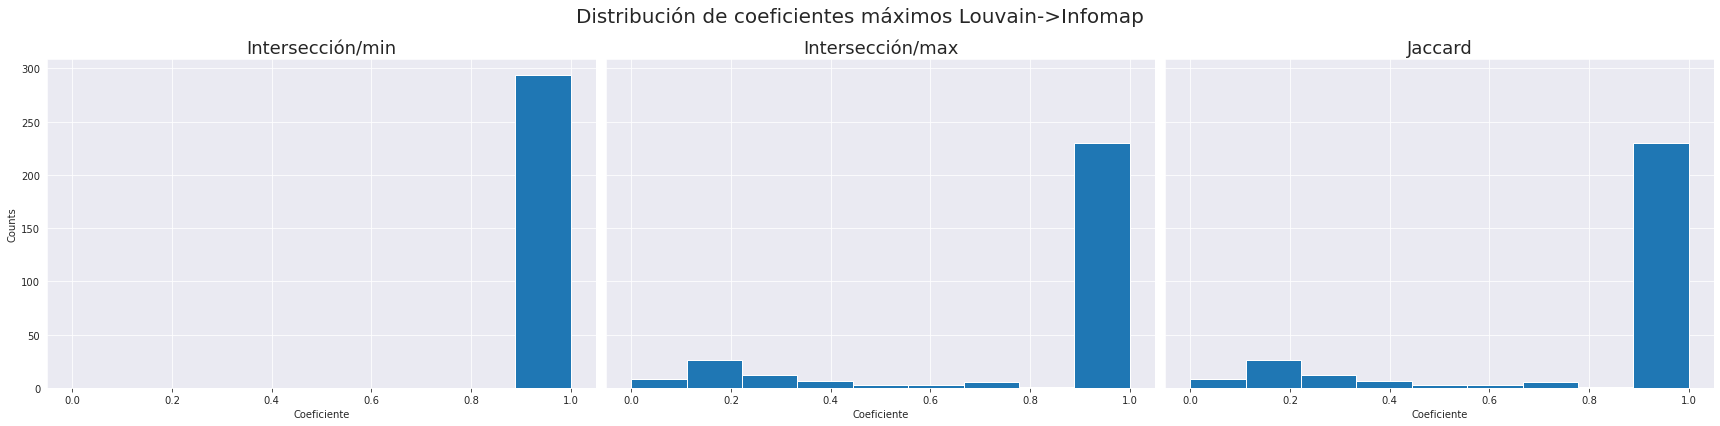

In [18]:
metricas = {"Intersección/min":df_min,"Intersección/max":df_max, "Jaccard":df_jaccard}

fig, ax = plt.subplots(1,3, figsize=(24,6), sharey=True)
fig.suptitle("Distribución de coeficientes máximos Louvain->Infomap", fontsize=20)
i=0
for name,data in metricas.items():
    ax[i].hist(data.T.max().values, bins=np.linspace(0,1,10))
    ax[i].set_title(f"{name}", fontsize=18)
    ax[i].set_xlabel("Coeficiente")
    i+=1

ax[0].set_ylabel("Counts")

plt.tight_layout()

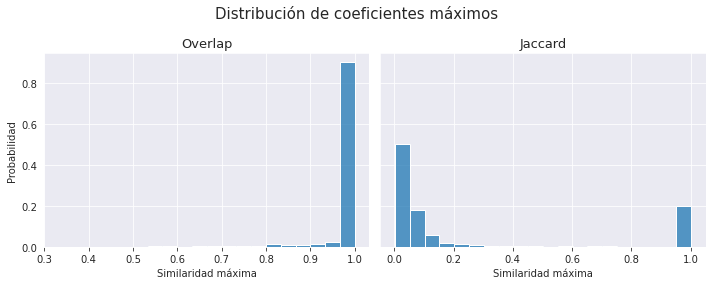

In [135]:
metricas = {"Overlap":df_min,"Jaccard":df_jaccard}

fig, ax = plt.subplots(1,2, figsize=(10,4),sharey=True)
fig.suptitle("Distribución de coeficientes máximos", fontsize=15)

i=0
for name,data in metricas.items():
    ax[i].set_title(f"{name}", fontsize=13)
    ax[i].set_xlabel("Similaridad máxima")
    if i == 0:
        ax[i].set_ylabel("Probabilidad")
    sns.histplot(data.max(),stat="probability", ax=ax[i], bins=20)
    i+=1

plt.tight_layout()
plt.savefig("../../../reports/figs_p_tesis/hist_comunidades_contenidas.png", dpi=300)

# Quiero ver si las comunidades suelen tener Berts

In [64]:
bert_groups = enfermedades[enfermedades.node_type == "bert_group"]
berts_infomap = pd.DataFrame(bert_groups.comunidades_infomap.value_counts()).reset_index().rename(columns={"comunidades_infomap":"num_berts","index":"comunidad"}).astype({"comunidad":"int"})
berts_louvain = pd.DataFrame(bert_groups.comunidades_louvain.value_counts()).reset_index().rename(columns={"comunidades_louvain":"num_berts","index":"comunidad"}).astype({"comunidad":"int"})

rows_infomap = pd.DataFrame.from_dict({comunidad:0 for comunidad in comunidades_infomap if comunidad not in berts_infomap.comunidad.values},orient="index").reset_index().rename(columns={"index":"comunidad",0:"num_berts"})
rows_louvain = pd.DataFrame.from_dict({comunidad:0 for comunidad in comunidades_louvain if comunidad not in berts_louvain.comunidad.values},orient="index").reset_index().rename(columns={"index":"comunidad",0:"num_berts"})

berts_infomap = pd.concat([berts_infomap,rows_infomap])
berts_louvain = pd.concat([berts_louvain,rows_louvain])

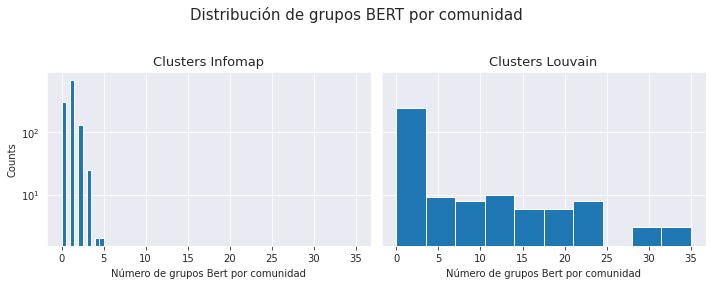

In [92]:
values_infomap = berts_infomap.num_berts.values
values_louvain = berts_louvain.num_berts.values

fig, ax = plt.subplots(1,2,figsize=(10,4), sharey=True,sharex=True)
fig.suptitle("Distribución de grupos BERT por comunidad\n",fontsize=15)
ticks = np.logspace(0,values_louvain.max(),10)

ax[0].hist(values_infomap,log=True)
ax[0].set_title("Clusters Infomap", fontsize=13)
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Número de grupos Bert por comunidad")

ax[1].hist(values_louvain,log=True)
ax[1].set_title("Clusters Louvain", fontsize=13)
ax[1].set_xlabel("Número de grupos Bert por comunidad")

plt.tight_layout()

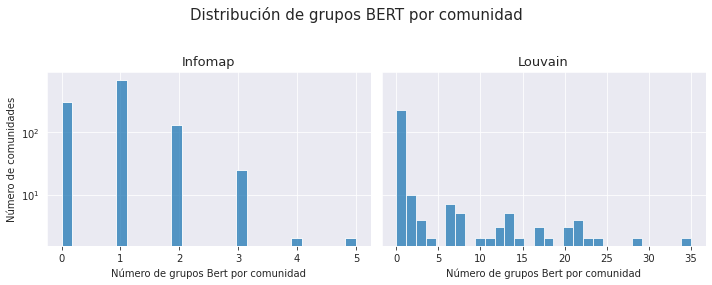

In [107]:
fig, ax = plt.subplots(1,2, figsize=(10,4),sharey=True)
fig.suptitle("Distribución de grupos BERT por comunidad\n", fontsize=15)

berts_casos = {"Infomap":berts_infomap, "Louvain":berts_louvain}

i=0
for name,data in berts_casos.items():
    ax[i].set_title(f"{name}", fontsize=13)
    ax[i].set_xlabel("Número de grupos Bert por comunidad")
    ax[i].set_yscale("log")
    if i == 0:
        ax[i].set_ylabel("Número de comunidades")
        sns.histplot(data.num_berts,stat="count", ax=ax[i])
    else:
        sns.histplot(data.num_berts,stat="count", ax=ax[i],bins=30)
    i+=1

plt.tight_layout()
plt.savefig("../../../reports/figs_p_tesis/dist_berts.png", dpi=300)

In [122]:
def pie_plot_ax(ax, df,colname, other_percent, other_name):
    tot = len(df)
    vals = df[colname].value_counts()
    percent = vals.apply(lambda x: round((x*100)/tot))
    percent = percent.drop(index=percent[percent < other_percent].index.values)
    percent[other_name] = 100 - percent.sum()

    ax.pie(percent.values, labels=percent.index, autopct=lambda p: f'{p:.0f}%' if p > 6 else '',
           shadow=False, startangle=90, textprops={'size': 'large'}, radius=0.9)

In [24]:
fig1 = px.histogram(berts_louvain["num_berts"],x="num_berts", title="Clusters Louvain",nbins=80,log_y=True)
fig1.show()

fig2 = px.histogram(berts_infomap["num_berts"],x="num_berts", title="Clusters Infomap")
fig2.show()

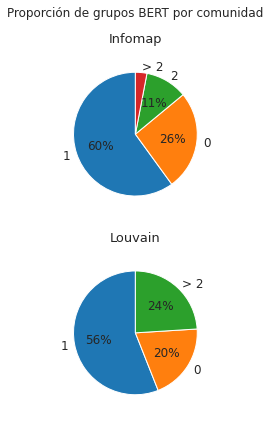

In [132]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
fig.suptitle("Proporción de grupos BERT por comunidad")
berts_comunidades_casos = {"Infomap":berts_infomap, "Louvain":berts_louvain}

i=0
for name,data in berts_comunidades_casos.items():
    ax[i].set_title(f"{name}", fontsize=13)
    pie_plot_ax(ax[i],data,"num_berts",10,"> 2")
    i += 1


plt.tight_layout()
plt.savefig("../../../reports/figs_p_tesis/tortas_dist_berts_comunidades.svg", dpi=300, format="svg")

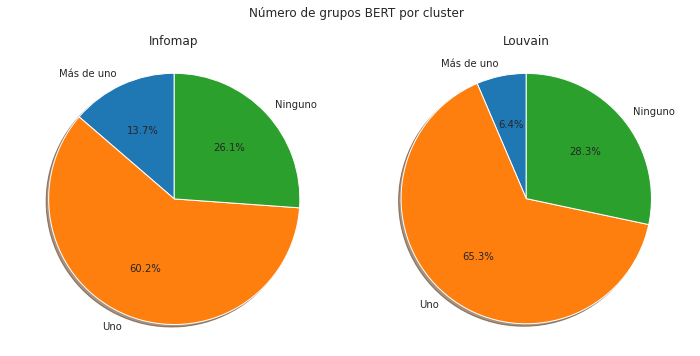

In [26]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Número de grupos BERT por cluster")

ninguno_infomap = infomap_valores[0]
unico_infomap = infomap_valores[1]

ax[0].pie([mas_de_uno_infomap,unico_infomap,ninguno_infomap], labels=["Más de uno", "Uno", "Ninguno"], autopct='%1.1f%%',shadow=True, startangle=90)
ax[0].axis('equal') 
ax[0].set_title("Infomap")


ninguno_louvain = louvain_valores[0]
unico_louvain = louvain_valores[1]

ax[1].pie([mas_de_uno_louvain,unico_infomap,ninguno_infomap], labels=["Más de uno", "Uno", "Ninguno"], autopct='%1.1f%%',shadow=True, startangle=90)
ax[1].axis('equal') 
ax[1].set_title("Louvain")

plt.tight_layout()

# fig.savefig("../../reports/analisis_comunidades/tortas_bert.png", dpi=200)

# Veo inclusión de infomap en louvain

Hago una adaptación del coeficiente sobre mínimo, en vez de mínimo pongo infomap

In [27]:
def int_min_infomap(set_infomap,set_louvain):
    intersection = len(set_infomap&set_louvain)
    min_set = len(set_infomap)
    return intersection/min_set

In [28]:
matrix_min_infomap = {}

for comunidad_infomap,set_infomap in conjuntos_infomap.items():
    partial_min_infomap = {}
    for comunidad_louvain, set_louvain in conjuntos_louvain.items():
        coef_min_infomap = int_min_infomap(set_infomap,set_louvain)
        partial_min_infomap[comunidad_louvain] = coef_min_infomap
    matrix_min_infomap[comunidad_infomap] = partial_min_infomap

df_min_infomap = pd.DataFrame(matrix_min_infomap)

/tmp/ipykernel_15529/145107736.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_15529/145107736.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



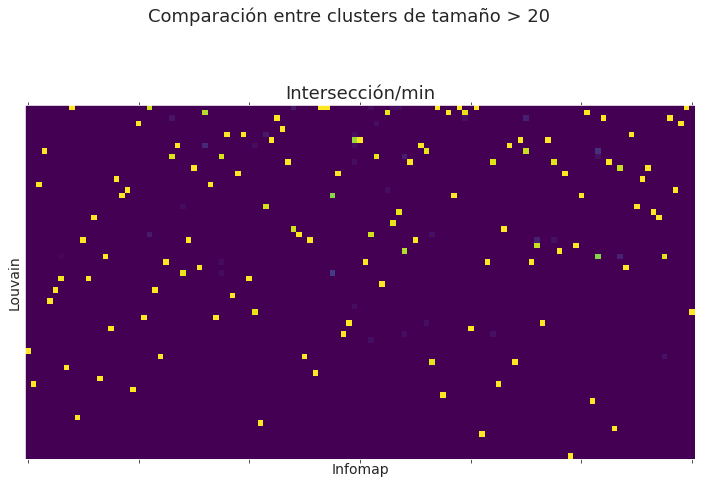

In [29]:
n = 20

infomap_corte = infomap_clusters.sort_values(by="tamaño", ascending=False)[infomap_clusters.tamaño > n].comunidad.values
louvain_corte = louvain_clusters.sort_values(by="tamaño", ascending=False)[louvain_clusters.tamaño > n].comunidad.values

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle(f"Comparación entre clusters de tamaño > {n}", fontsize=18)

min_infomap_mat = df_min_infomap.loc[louvain_corte,infomap_corte]

cmap = "viridis"

im = ax.matshow(min_infomap_mat,
                cmap=cmap)
ax.set_title("Intersección/min", fontsize=18)
# cbar = fig.colorbar(im, ax=ax1)
ax.tick_params(labelbottom=False, labelleft=False,labeltop=False)
ax.set_xlabel("Infomap", fontsize=14)
ax.set_ylabel("Louvain", fontsize=14)
ax.grid(False)

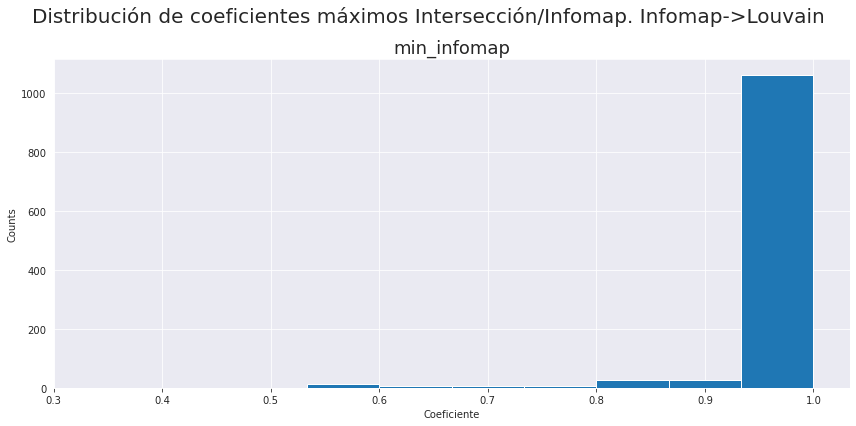

In [30]:
data = df_min_infomap
name = "min_infomap"

fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle("Distribución de coeficientes máximos Intersección/Infomap. Infomap->Louvain", fontsize=20)
i=0

ax.hist(data.max().values)
ax.set_title(f"{name}", fontsize=18)
ax.set_xlabel("Coeficiente")
ax.set_ylabel("Counts")

plt.tight_layout()
# plt.savefig("../../../reports/analisis_comunidades/interseccion_infomap.png", dpi=200)

# Veo si las particiones capturan las estrellitas

Voy a tomar el ego network de cada nodo bert (en principio a orden 1, después veo si tiene sentido tomar a orden 2).

Una vez que tengo todas las ego networks, saco los conjuntos de nodos de cada una y hago un jaccard con infomap, como había hecho antes con infomap y louvain

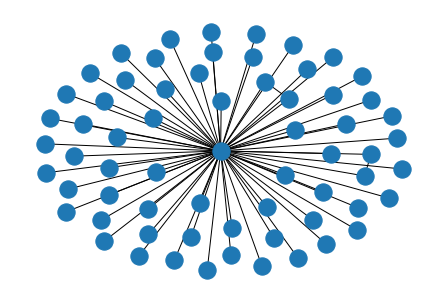

In [31]:
G = nx.read_gml(graph_data+"nohub_disease_layer.gml")
bert_groups = graph_node_data.loc[graph_node_data.node_type == "bert_group","node_index"].values
ego_1 = {node: nx.ego_graph(G,str(node),1) for node in bert_groups}
nx.draw(ego_1[7])

In [138]:
conjuntos_berts = {center:set(ego.nodes()) for center, ego in ego_1.items()}
conjuntos_berts = {center: {int(item) for item in ego} for center,ego in conjuntos_berts.items()}

NameError: name 'ego_1' is not defined

## Comparación con todas las particiones (esto no va)

### Comparo con infomap

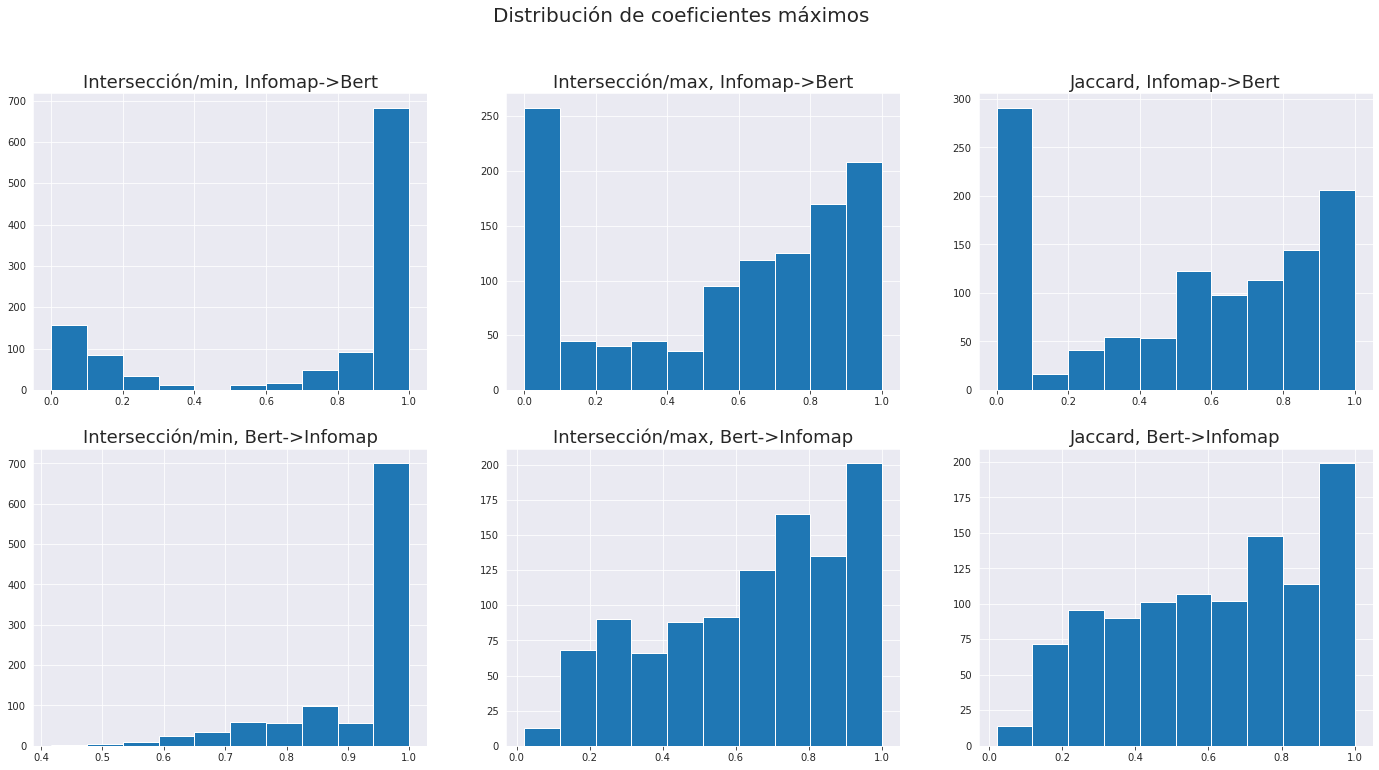

In [196]:
matrix_jaccard_bert_infomap = {}
matrix_min_bert_infomap = {}
matrix_max_bert_infomap = {}

for comunidad_infomap,set_infomap in conjuntos_infomap.items():
    partial_jaccard = {}
    partial_min = {}
    partial_max = {}
    for bert, set_bert in conjuntos_berts.items():
        coef_jaccard = jaccard(set_infomap,set_bert)
        coef_min = int_min(set_infomap,set_bert)
        coef_max = int_max(set_infomap,set_bert)
        partial_jaccard[bert] = coef_jaccard
        partial_min[bert] = coef_min
        partial_max[bert] = coef_max
    matrix_jaccard_bert_infomap[comunidad_infomap] = partial_jaccard
    matrix_min_bert_infomap[comunidad_infomap] = partial_min
    matrix_max_bert_infomap[comunidad_infomap] = partial_max

df_jaccard_bert_infomap = pd.DataFrame(matrix_jaccard_bert_infomap)
df_min_bert_infomap = pd.DataFrame(matrix_min_bert_infomap)
df_max_bert_infomap = pd.DataFrame(matrix_max_bert_infomap)

metricas = {"Intersección/min":df_min_bert_infomap,"Intersección/max":df_max_bert_infomap, "Jaccard":df_jaccard_bert_infomap}

fig, ax = plt.subplots(2,3, figsize=(24,12))
fig.suptitle("Distribución de coeficientes máximos", fontsize=20)

i=0
for name,data in metricas.items():
    ax[0,i].hist(data.max().values)
    ax[0,i].set_title(f"{name}, Infomap->Bert", fontsize=18)

    ax[1,i].hist(data.T.max().values)
    ax[1,i].set_title(f"{name}, Bert->Infomap", fontsize=18)
    i+=1

fig.savefig(reports_comunidades+"inclusion_berts_infomap.png",dpi=200)


/tmp/ipykernel_32209/806342359.py:23: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



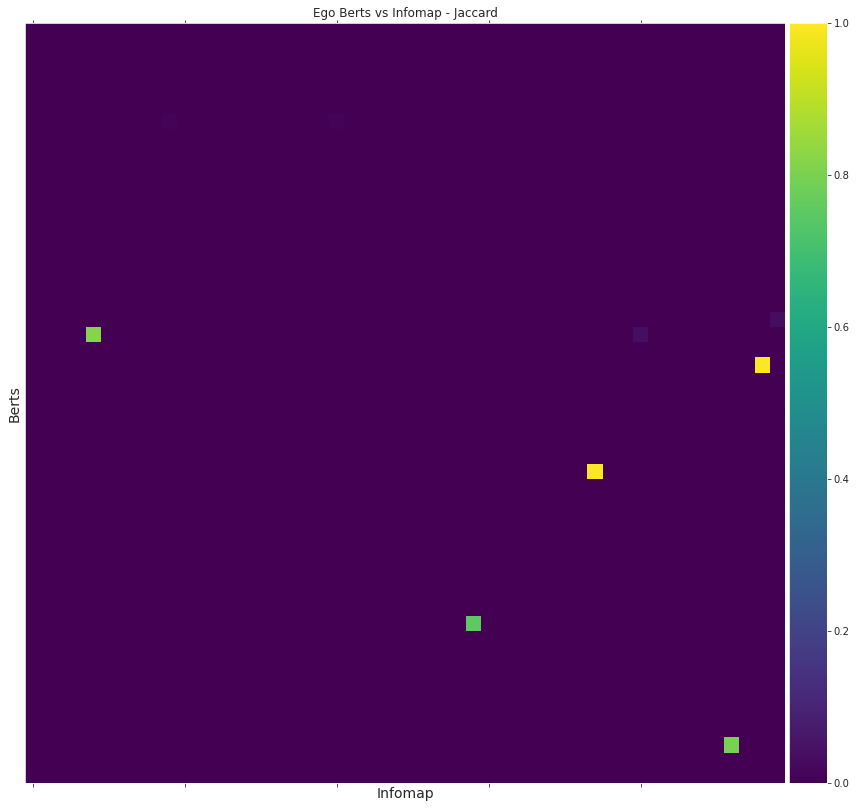

In [167]:
n = 20

# infomap_corte = infomap_clusters.sort_values(by="tamaño", ascending=False)[infomap_clusters.tamaño > 10].comunidad.values
infomap_corte = np.random.choice(infomap_clusters.comunidad.values, 50)
berts_corte = np.random.choice(bert_groups,50)

fig, ax = plt.subplots(figsize=(12,24))
# fig.suptitle("Ego Berts vs Infomap - Jaccard")
ax.set_title("Ego Berts vs Infomap - Jaccard")
jaccard_mat = df_jaccard_bert_infomap.loc[berts_corte,infomap_corte]
# jaccard_mat = df_jaccard_bert_infomap
cmap = "viridis"

im = ax.matshow(jaccard_mat,cmap=cmap, vmin=0, vmax=1)
ax1.set_title("Jaccard", fontsize=18)
# cbar = fig.colorbar(im, ax=ax1)
ax.tick_params(labelbottom=False, labelleft=False,labeltop=False)
ax.set_xlabel("Infomap", fontsize=14)
ax.set_ylabel("Berts", fontsize=14)
ax.grid(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04, cax=cax)


plt.tight_layout()

### Comparo con Louvain

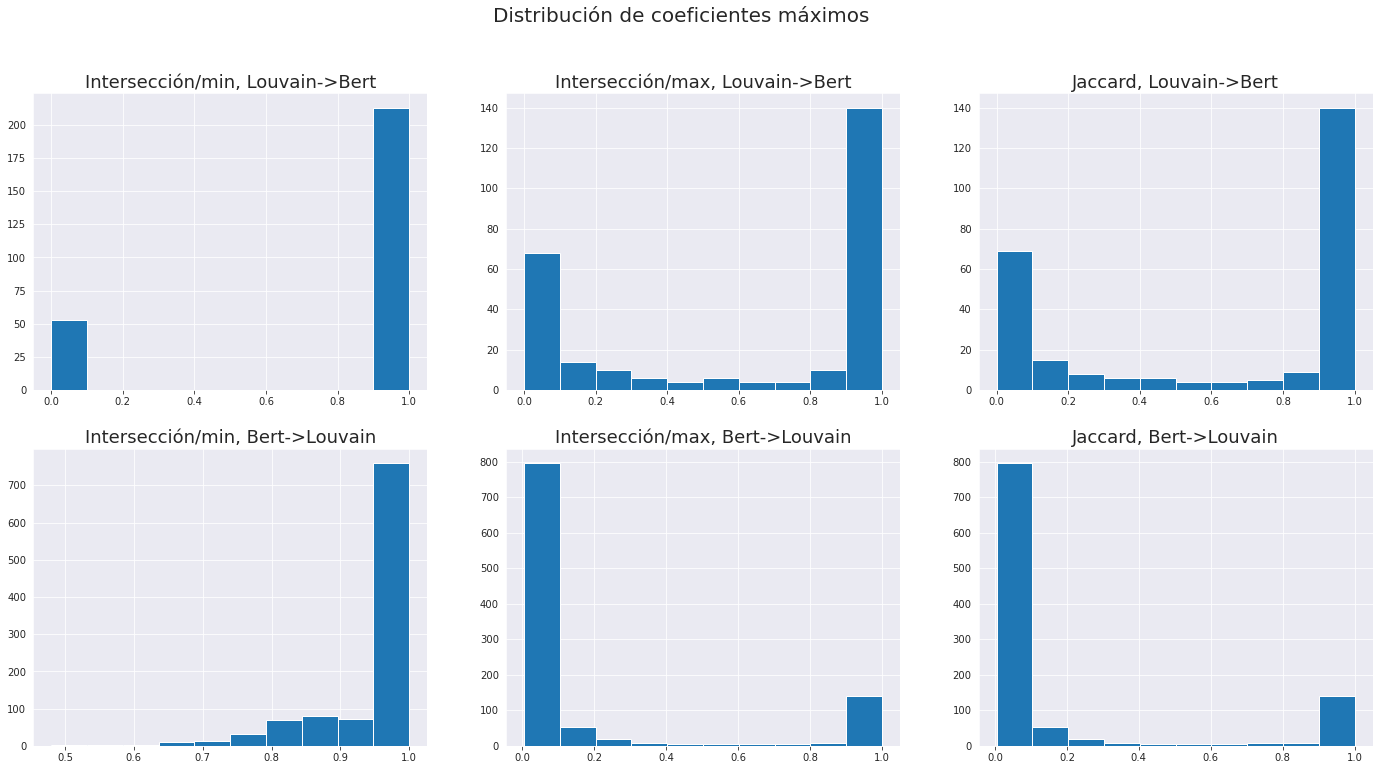

In [197]:
matrix_jaccard_bert_louvain= {}
matrix_min_bert_louvain = {}
matrix_max_bert_louvain = {}

for comunidad_louvain,set_louvain in conjuntos_louvain.items():
    partial_jaccard = {}
    partial_min = {}
    partial_max = {}
    for bert, set_bert in conjuntos_berts.items():
        coef_jaccard = jaccard(set_louvain,set_bert)
        coef_min = int_min(set_louvain,set_bert)
        coef_max = int_max(set_louvain,set_bert)
        partial_jaccard[bert] = coef_jaccard
        partial_min[bert] = coef_min
        partial_max[bert] = coef_max
    matrix_jaccard_bert_louvain[comunidad_louvain] = partial_jaccard
    matrix_min_bert_louvain[comunidad_louvain] = partial_min
    matrix_max_bert_louvain[comunidad_louvain] = partial_max

df_jaccard_bert_louvain = pd.DataFrame(matrix_jaccard_bert_louvain)
df_min_bert_louvain = pd.DataFrame(matrix_min_bert_louvain)
df_max_bert_louvain = pd.DataFrame(matrix_max_bert_louvain)

metricas = {"Intersección/min":df_min_bert_louvain,"Intersección/max":df_max_bert_louvain, "Jaccard":df_jaccard_bert_louvain}

fig, ax = plt.subplots(2,3, figsize=(24,12))
fig.suptitle("Distribución de coeficientes máximos", fontsize=20)

i=0
for name,data in metricas.items():
    ax[0,i].hist(data.max().values)
    ax[0,i].set_title(f"{name}, Louvain->Bert", fontsize=18)

    ax[1,i].hist(data.T.max().values)
    ax[1,i].set_title(f"{name}, Bert->Louvain", fontsize=18)
    i+=1

# fig.savefig(reports_comunidades+"inclusion_berts_louvain.png",dpi=200)

## Comparación vs su propia comunidad (esto si)

In [136]:
comunidades_bert = enfermedades.loc[enfermedades.node_type == "bert_group",["node_index","comunidades_infomap","comunidades_louvain"]].astype({"comunidades_infomap":"int","comunidades_louvain":"int"}).set_index("node_index").to_dict(orient="index")

In [137]:
metricas_infomap = {}
metricas_louvain = {}

for bert,comunidades in comunidades_bert.items():
    conjunto_ego = conjuntos_berts[bert]

    infomap = comunidades["comunidades_infomap"]
    conjunto_infomap = conjuntos_infomap[infomap]

    louvain = comunidades["comunidades_louvain"]
    conjunto_louvain = conjuntos_louvain[louvain]

    interseccion_bert_infomap = round(len(conjunto_ego&conjunto_infomap)/len(conjunto_ego),2)
    interseccion_bert_louvain = round(len(conjunto_ego&conjunto_louvain)/len(conjunto_ego),2)

    jaccard_bert_infomap = round(len(conjunto_ego&conjunto_infomap)/len(conjunto_ego|conjunto_infomap),2)
    jaccard_bert_louvain = round(len(conjunto_ego&conjunto_louvain)/len(conjunto_ego|conjunto_louvain),2)

    bert_tamaño_infomap = round(len(conjunto_ego)/len(conjunto_infomap),2)
    bert_tamaño_louvain = round(len(conjunto_ego)/len(conjunto_louvain),2)

    metricas_parcial_infomap = {"interseccion_sobre_bert":interseccion_bert_infomap, "jaccard":jaccard_bert_infomap, "tamaño_bert_sobre_cluster":bert_tamaño_infomap}
    metricas_parcial_louvain = {"interseccion_sobre_bert":interseccion_bert_louvain, "jaccard":jaccard_bert_louvain, "tamaño_bert_sobre_cluster":bert_tamaño_louvain}

    metricas_infomap[bert] = metricas_parcial_infomap
    metricas_louvain[bert] = metricas_parcial_louvain


df_berts_comunidades = pd.DataFrame.from_dict(comunidades_bert).T

df_metricas_bert_infomap = pd.DataFrame.from_dict(metricas_infomap).T
df_metricas_bert_infomap = pd.concat([df_berts_comunidades["comunidades_infomap"],df_metricas_bert_infomap], axis=1).reset_index().rename(columns={"index":"node_index"})

df_metricas_bert_louvain = pd.DataFrame.from_dict(metricas_louvain).T
df_metricas_bert_louvain = pd.concat([df_berts_comunidades["comunidades_louvain"],df_metricas_bert_louvain], axis=1).reset_index().rename(columns={"index":"node_index"})


NameError: name 'conjuntos_berts' is not defined

In [35]:
df_metricas_bert_louvain

,node_index,comunidades_louvain,interseccion_sobre_bert,jaccard,tamaño_bert_sobre_cluster
0,7,18,0.71,0.12,0.18
1,2938,24,0.93,0.06,0.07
2,4310,20,0.89,0.08,0.09
3,18238,20,0.90,0.18,0.20
4,14406,18,0.86,0.02,0.02
...,...,...,...,...,...
1035,18248,274,1.00,1.00,1.00
1036,18264,113,1.00,1.00,1.00
1037,18276,5,1.00,0.02,0.02
1038,18361,107,1.00,1.00,1.00


In [36]:
# metricas = {"Intersección/Bert":df_min_bert_infomap,"Intersección/max":df_max_bert_infomap, "Jaccard":df_jaccard_bert_infomap}

# fig, ax = plt.subplots(2,3, figsize=(24,12))
# fig.suptitle("Distribución de coeficientes máximos", fontsize=20)

# i=0
# for name,data in metricas.items():
#     ax[0,i].hist(data.max().values)
#     ax[0,i].set_title(f"{name}, Infomap->Bert", fontsize=18)

#     ax[1,i].hist(data.T.max().values)
#     ax[1,i].set_title(f"{name}, Bert->Infomap", fontsize=18)
#     i+=1

# fig.savefig(reports_comunidades+"inclusion_berts_infomap.png",dpi=200)

NameError: name 'df_min_bert_infomap' is not defined

In [37]:
df_metricas_bert_louvain

,node_index,comunidades_louvain,interseccion_sobre_bert,jaccard,tamaño_bert_sobre_cluster
0,7,18,0.71,0.12,0.18
1,2938,24,0.93,0.06,0.07
2,4310,20,0.89,0.08,0.09
3,18238,20,0.90,0.18,0.20
4,14406,18,0.86,0.02,0.02
...,...,...,...,...,...
1035,18248,274,1.00,1.00,1.00
1036,18264,113,1.00,1.00,1.00
1037,18276,5,1.00,0.02,0.02
1038,18361,107,1.00,1.00,1.00


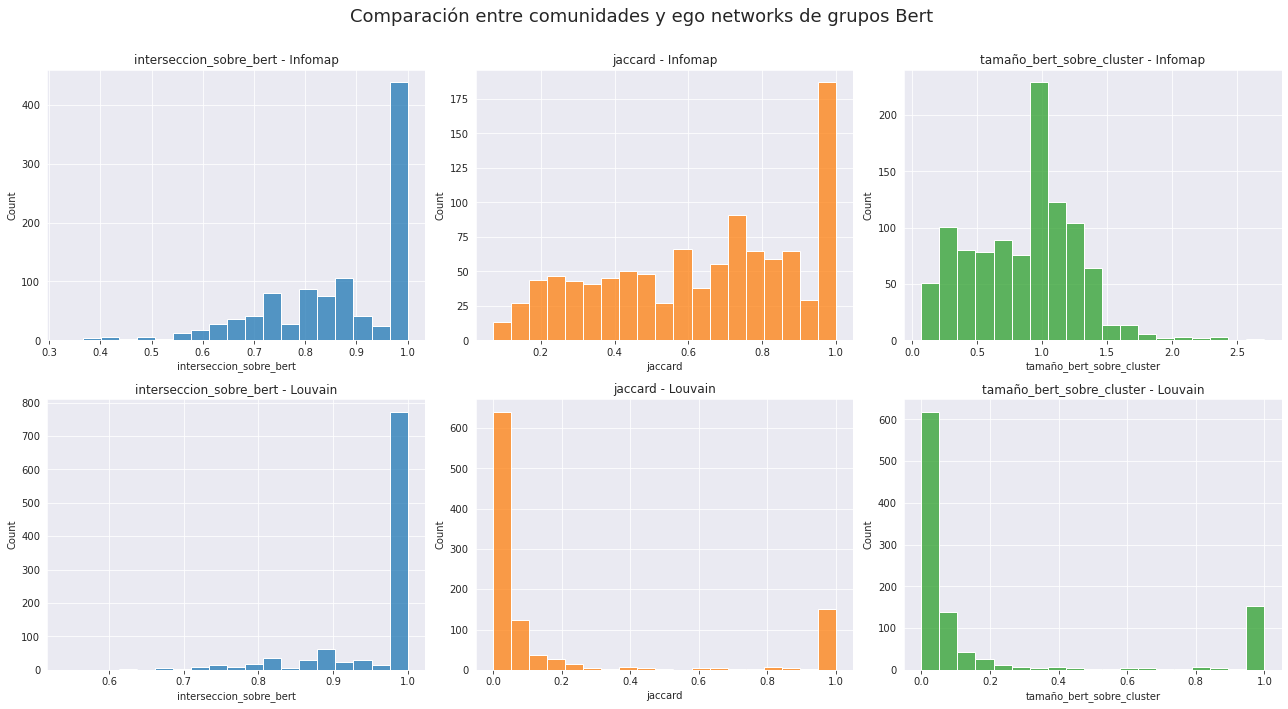

In [38]:
metricas = ["interseccion_sobre_bert", "jaccard", "tamaño_bert_sobre_cluster"]
fig, ax  = plt.subplots(2,3,figsize=(18,10))
fig.suptitle("Comparación entre comunidades y ego networks de grupos Bert \n", fontsize=18)

for i in range(3):
    current_ax = ax[0,i]
    current_ax.set_title(f"{metricas[i]} - Infomap")
    data = df_metricas_bert_infomap[metricas[i]]
    sns.histplot(data=data, ax=current_ax, color=sns.color_palette()[i], bins=np.linspace(data.min().min(), data.max().max(), 20))

for i in range(3):
    current_ax = ax[1,i]
    current_ax.set_title(f"{metricas[i]} - Louvain")
    data = df_metricas_bert_louvain[metricas[i]]
    sns.histplot(data=data, ax=current_ax, color=sns.color_palette()[i], bins=np.linspace(data.min().min(), data.max().max(), 20))

plt.tight_layout()
# plt.savefig(reports_comunidades+"ego_networks_vs_comunidades.png", dpi=200)

# Veo si "mapeos bert" tiene overlap con comunidades

In [145]:
bert_edges = pd.read_csv(graph_data+"disease_bert_edges.csv").drop(columns=["Unnamed: 0"])

In [149]:
bert_nodes = graph_node_data[graph_node_data.node_type == "bert_group"].node_index.values
bert_subgraphs = {}

for group in bert_nodes:
    conjunto_bert = set(bert_edges.loc[bert_edges.x_index == group, "y_index"].values)
    conjunto_bert.update([group])
    bert_subgraphs[group] = conjunto_bert

In [151]:
comunidades_bert = enfermedades.loc[enfermedades.node_type == "bert_group",["node_index","comunidades_infomap","comunidades_louvain"]].astype({"comunidades_infomap":"int","comunidades_louvain":"int"}).set_index("node_index").to_dict(orient="index")

In [170]:
metricas_infomap = {}
metricas_louvain = {}

for bert,comunidades in comunidades_bert.items():
    conjunto_mapeo = bert_subgraphs[bert]

    infomap = comunidades["comunidades_infomap"]
    conjunto_infomap = conjuntos_infomap[infomap]

    louvain = comunidades["comunidades_louvain"]
    conjunto_louvain = conjuntos_louvain[louvain]

    interseccion_bert_infomap = len(conjunto_mapeo&conjunto_infomap)/len(conjunto_mapeo)
    interseccion_bert_louvain = len(conjunto_mapeo&conjunto_louvain)/len(conjunto_mapeo)

    jaccard_bert_infomap = len(conjunto_mapeo&conjunto_infomap)/len(conjunto_mapeo|conjunto_infomap)
    jaccard_bert_louvain = len(conjunto_mapeo&conjunto_louvain)/len(conjunto_mapeo|conjunto_louvain)

    bert_tamaño_infomap = round(len(conjunto_mapeo)/len(conjunto_infomap),2)
    bert_tamaño_louvain = round(len(conjunto_mapeo)/len(conjunto_louvain),2)

    metricas_parcial_infomap = {"interseccion_sobre_bert":interseccion_bert_infomap, "jaccard":jaccard_bert_infomap, "tamaño_bert_sobre_cluster":bert_tamaño_infomap}
    metricas_parcial_louvain = {"interseccion_sobre_bert":interseccion_bert_louvain, "jaccard":jaccard_bert_louvain, "tamaño_bert_sobre_cluster":bert_tamaño_louvain}

    metricas_infomap[bert] = metricas_parcial_infomap
    metricas_louvain[bert] = metricas_parcial_louvain


df_berts_comunidades = pd.DataFrame.from_dict(comunidades_bert).T

df_metricas_bert_infomap = pd.DataFrame.from_dict(metricas_infomap).T
df_metricas_bert_infomap = pd.concat([df_berts_comunidades["comunidades_infomap"],df_metricas_bert_infomap], axis=1).reset_index().rename(columns={"index":"node_index"})

df_metricas_bert_louvain = pd.DataFrame.from_dict(metricas_louvain).T
df_metricas_bert_louvain = pd.concat([df_berts_comunidades["comunidades_louvain"],df_metricas_bert_louvain], axis=1).reset_index().rename(columns={"index":"node_index"})

In [171]:
df_metricas_bert_infomap.interseccion_sobre_bert.value_counts()

1.0    1040
Name: interseccion_sobre_bert, dtype: int64

In [196]:
df_metricas_bert_infomap

,node_index,comunidades_infomap,interseccion_sobre_bert,jaccard,tamaño_bert_sobre_cluster
0,7,219,1.0,0.085714,0.09
1,2938,223,1.0,0.235294,0.24
2,4310,229,1.0,0.214286,0.21
3,18238,230,1.0,1.000000,1.00
4,14406,205,1.0,0.555556,0.56
...,...,...,...,...,...
1035,18248,1128,1.0,1.000000,1.00
1036,18264,929,1.0,1.000000,1.00
1037,18276,813,1.0,0.750000,0.75
1038,18361,899,1.0,1.000000,1.00


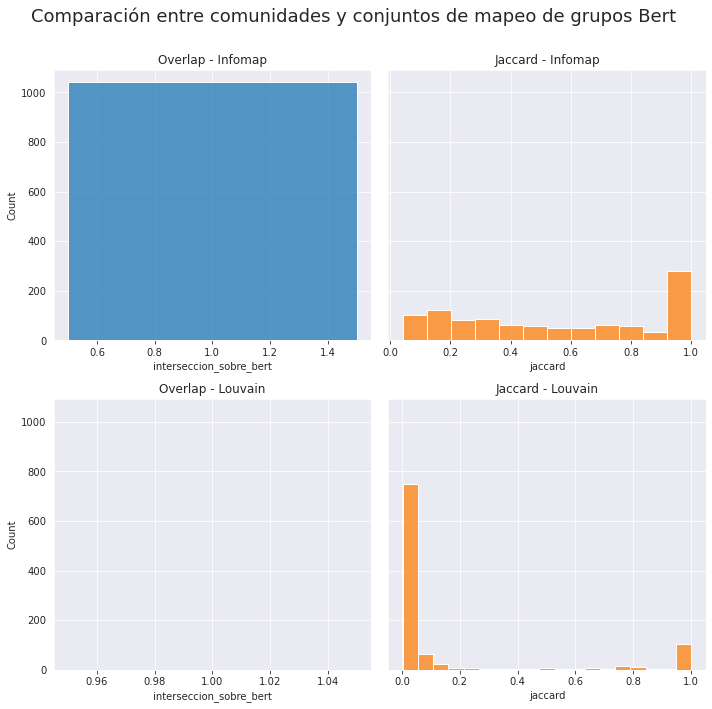

In [197]:
fig, ax = plt.subplots(2,2, figsize=(10,10),sharey=True)
fig.suptitle("Comparación entre comunidades y conjuntos de mapeo de grupos Bert \n", fontsize=18)
metricas = ["interseccion_sobre_bert", "jaccard"]
nombres = ["Overlap","Jaccard"]

for i in range(2):
    current_ax = ax[0,i]
    current_ax.set_title(f"{nombres[i]} - Infomap")
    data = df_metricas_bert_infomap[metricas[i]]
    sns.histplot(data=data, ax=current_ax, color=sns.color_palette()[i],stat="count")

for i in range(2):
    current_ax = ax[1,i]
    current_ax.set_title(f"{nombres[i]} - Louvain")
    data = df_metricas_bert_louvain[metricas[i]]
    sns.histplot(data=data, ax=current_ax, color=sns.color_palette()[i], bins=np.linspace(data.min().min(), data.max().max(), 20),stat="count")

plt.tight_layout()
plt.savefig("../../../reports/figs_p_tesis/inclusion_bert_comunidades.png", dpi=300)

In [200]:
df_metricas_bert_infomap["interseccion_sobre_bert"].values

array([1., 1., 1., ..., 1., 1., 1.])

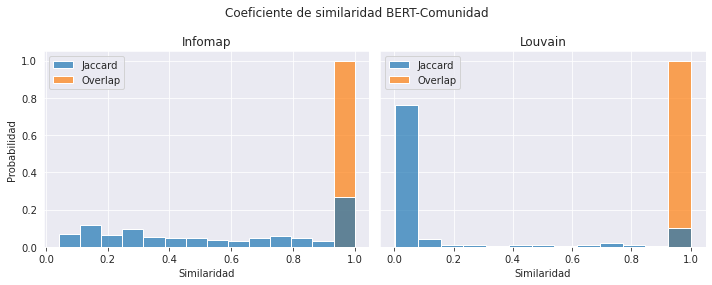

In [238]:
valores_overlap_infomap = df_metricas_bert_infomap["interseccion_sobre_bert"].values
valores_jaccard_infomap = df_metricas_bert_infomap["jaccard"].values

valores_overlap_louvain = df_metricas_bert_louvain["interseccion_sobre_bert"].values
valores_jaccard_louvain = df_metricas_bert_louvain["jaccard"].values


fig, ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
ax[0].set_title("Infomap")
ax[1].set_title("Louvain")
ax[0].set_xlabel("Similaridad")
ax[1].set_xlabel("Similaridad")
ax[0].set_ylabel("Probabilidad")

sns.histplot(data=pd.DataFrame({"Overlap":valores_overlap_infomap,"Jaccard":valores_jaccard_infomap}),ax=ax[0], palette="tab10",multiple="layer",alpha=0.7,stat="probability",hue_order=["Jaccard","Overlap"],common_norm=False)
sns.histplot(data=pd.DataFrame({"Overlap":valores_overlap_louvain,"Jaccard":valores_jaccard_louvain}),ax=ax[1], palette="tab10",multiple="layer",alpha=0.7,stat="probability",hue_order=["Jaccard","Overlap"],common_norm=False)
fig.suptitle("Coeficiente de similaridad BERT-Comunidad")

plt.tight_layout()

plt.savefig("../../../reports/figs_p_tesis/inclusion_bert_comunidades.png", dpi=300)

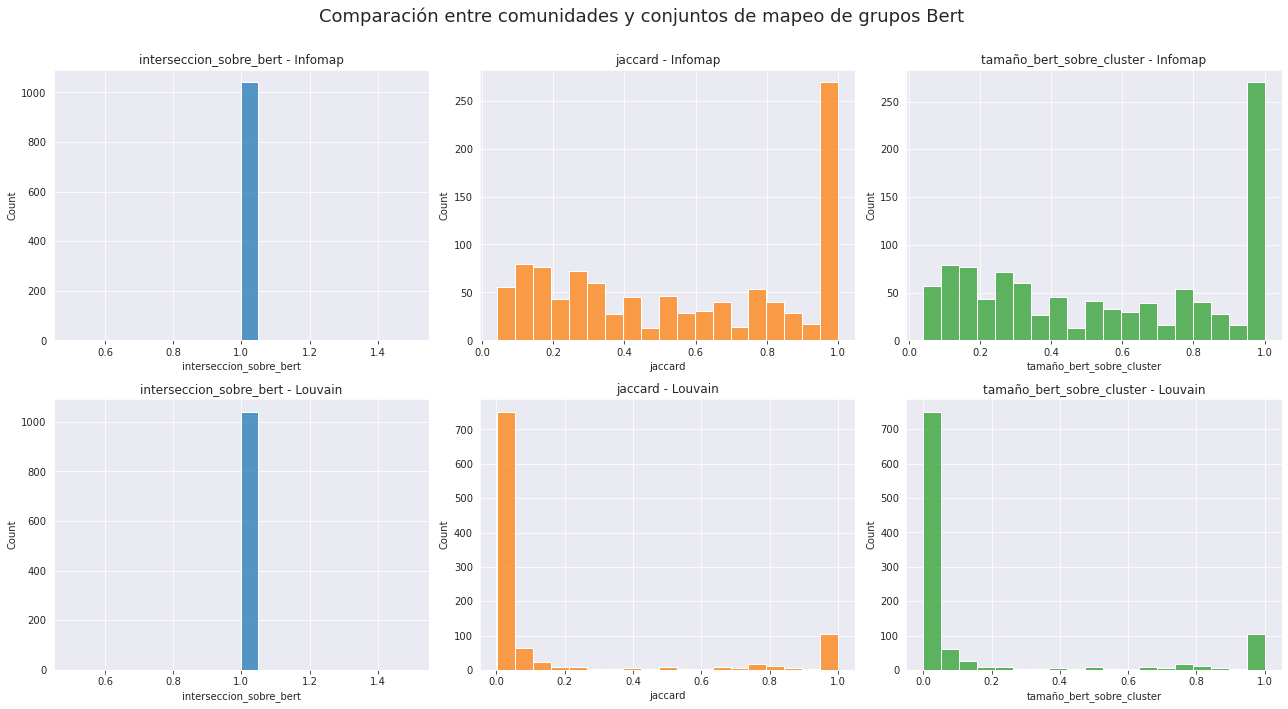

In [173]:
metricas = ["interseccion_sobre_bert", "jaccard", "tamaño_bert_sobre_cluster"]
fig, ax  = plt.subplots(2,3,figsize=(18,10))
fig.suptitle("Comparación entre comunidades y conjuntos de mapeo de grupos Bert \n", fontsize=18)

current_ax = ax[0,0]
current_ax.set_title(f"{metricas[0]} - Infomap")
data = df_metricas_bert_infomap[metricas[0]]
sns.histplot(data=data, ax=current_ax, color=sns.color_palette()[0], bins=20)


current_ax = ax[1,0]
current_ax.set_title(f"{metricas[0]} - Louvain")
data = df_metricas_bert_louvain[metricas[0]]
sns.histplot(data=data, ax=current_ax, color=sns.color_palette()[0], bins=20)

for i in range(2):
    current_ax = ax[0,i+1]
    current_ax.set_title(f"{metricas[i+1]} - Infomap")
    data = df_metricas_bert_infomap[metricas[i+1]]
    sns.histplot(data=data, ax=current_ax, color=sns.color_palette()[i+1], bins=np.linspace(data.min().min(), data.max().max(), 20))

for i in range(2):
    current_ax = ax[1,i+1]
    current_ax.set_title(f"{metricas[i+1]} - Louvain")
    data = df_metricas_bert_louvain[metricas[i+1]]
    sns.histplot(data=data, ax=current_ax, color=sns.color_palette()[i+1], bins=np.linspace(data.min().min(), data.max().max(), 20))

plt.tight_layout()
# plt.savefig(reports_comunidades+"mapeos_vs_comunidades.png", dpi=200)

Conclusiones: 

Infomap y Louvain nunca "parten" mapeos bert: esto lo veo con intersección/bert, porque siempre siempre da 1. 

Los nodos bert tienen cierta influencia sobre las comunidades. Están totalmente contenidos en sus comunidades. 
Infomap parece estar más sesgado por los berts que louvain: las comunidades suelen tener un solo bert o un número pequeño de berts (no > 5), mientras que louvain también captura comunidades con un número mayor de berts (>10 y hasta 35).

Tomando el análisis que hicieron los de PrimeKG, esto ya nos habla de una similaridad dentro de las comunidades, porque esos nodos fueron agrupados en función de la similaridad de sus nombres en un espacio latente.

# Conectividad de comunidades con capa de genes

Quiero saber que tantos enlaces GDA tienen las distintas comunidades. Para cuantificar esto calculo:

Ver cantidad de enlaces GDA por comunidad. Puede ser la fracción de enfermedades con mapeo. Con las dos particiones.

De los que tienen enlaces, ver el numero medio de enlaces. 

Reportar las dos cosas.

In [50]:
# def get_node_dict(G):
#     return {node:data for (node,data) in list(G.nodes(data=True))}

# def node_labels_to_numeric(G):
#     new_labels = {old_label:int(old_label) for old_label in list(G.nodes)}
#     nx.relabel_nodes(G,new_labels,False)

In [51]:
gda_network = nx.read_gml(graph_data+"nohub_gda_network.gml", destringizer=int)

In [52]:
list(gda_network.nodes(data=True))[0]

(19599,
 {'node_type': 'disease',
  'node_name': 'Hepatomegaly',
  'node_id': 'C0019209',
  'node_source': 'disgenet'})

### Calculo fracción de nodos con mapeo y grado gda medio

In [53]:
cluster_gda_infomap = {}
for cluster in infomap_clusters.comunidad.values:
    cluster_nodes = enfermedades.loc[enfermedades.comunidades_infomap == cluster, "node_index"].values
    cluster_nodes_mapeados = enfermedades.loc[(enfermedades.comunidades_infomap == cluster) & (enfermedades.degree_gda != 0), "node_index"].values
    cant_nodos = len(cluster_nodes)
    cant_mapeos = len(cluster_nodes_mapeados)
    fraccion_mapeos = round(cant_mapeos/cant_nodos,2)

    valores_degree_gda = enfermedades.loc[(enfermedades.comunidades_infomap == cluster) & (enfermedades.degree_gda != 0), "degree_gda"].values
    if len(valores_degree_gda) == 0:
        promedio_degree_gda = 0
        max_degree_gda = 0
    else:
        promedio_degree_gda = round(np.mean(valores_degree_gda),2)
        max_degree_gda = max(valores_degree_gda)

    cluster_gda_infomap[cluster] = {"fraccion_gda":fraccion_mapeos, "grado_gda_medio":promedio_degree_gda, "max_grado_gda":max_degree_gda}

In [54]:
infomap_clusters = pd.merge(infomap_clusters,pd.DataFrame(cluster_gda_infomap).T, left_on="comunidad",right_index=True)

In [55]:
cluster_gda_louvain = {}
for cluster in louvain_clusters.comunidad.values:
    cluster_nodes = enfermedades.loc[enfermedades.comunidades_louvain == cluster, "node_index"].values
    cluster_nodes_mapeados = enfermedades.loc[(enfermedades.comunidades_louvain == cluster) & (enfermedades.degree_gda != 0), "node_index"].values
    cant_nodos = len(cluster_nodes)
    cant_mapeos = len(cluster_nodes_mapeados)
    fraccion_mapeos = round(cant_mapeos/cant_nodos,2)

    valores_degree_gda = enfermedades.loc[(enfermedades.comunidades_louvain == cluster) & (enfermedades.degree_gda != 0), "degree_gda"].values
    if len(valores_degree_gda) == 0:
        promedio_degree_gda = 0
        max_degree_gda = 0
    else:
        promedio_degree_gda = round(np.mean(valores_degree_gda),2)
        max_degree_gda = max(valores_degree_gda)

    cluster_gda_louvain[cluster] = {"fraccion_gda":fraccion_mapeos, "grado_gda_medio":promedio_degree_gda, "max_grado_gda":max_degree_gda}

In [56]:
louvain_clusters = pd.merge(louvain_clusters,pd.DataFrame(cluster_gda_louvain).T, left_on="comunidad",right_index=True)

In [59]:
# infomap_clusters.to_csv(reports_comunidades+"grado_gda_infomap.csv", index=False)
# louvain_clusters.to_csv(reports_comunidades+"grado_gda_louvain.csv", index=False)

### Distribución de métricas

Que veo en estos gráficos:

1- Como los clusters louvain son más grandes, me espero que tiendan a capturar más mapeos GDA que infomap. En contraparte, como los clusters infomap son chiquitos, espero que haya muchos con pocos mapeos.

2- Por como es la distribución de grado GDA nodo a nodo (muchos nodos con grado bajo y unos pocos outliers), me espero que la mayoría de los clusters tengan grado bajo y haya un par de outliers que capturaron los hubs GDA

3- Me dan una visión más "global" de algo que quiero ver a nivel cluster, tendría que analizarlo para algunos casos.

Text(0.5, 1.0, 'Louvain')

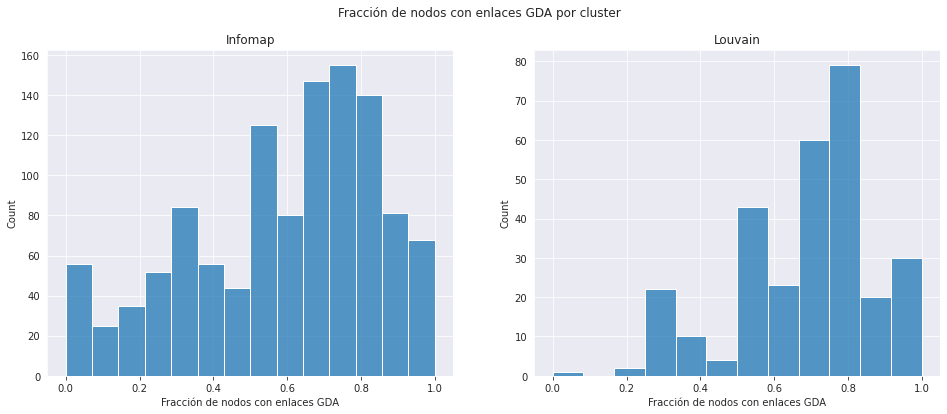

In [60]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle("Fracción de nodos con enlaces GDA por cluster")

sns.histplot(data=infomap_clusters, x="fraccion_gda", ax=ax[0])
ax[0].set_xlabel("Fracción de nodos con enlaces GDA")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters,x="fraccion_gda", ax=ax[1])
ax[1].set_xlabel("Fracción de nodos con enlaces GDA")
ax[1].set_title("Louvain")

# fig2.savefig("../../reports/analisis_comunidades/distribucion_tamaños.png", dpi=200)

Text(0.5, 1.0, 'Louvain')

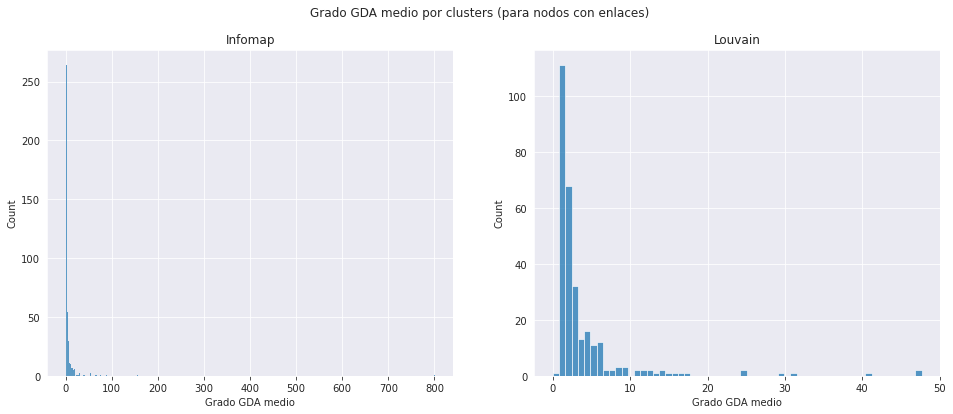

In [61]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle("Grado GDA medio por clusters (para nodos con enlaces)")

sns.histplot(data=infomap_clusters, x="grado_gda_medio", ax=ax[0])
ax[0].set_xlabel("Grado GDA medio")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters,x="grado_gda_medio", ax=ax[1])
ax[1].set_xlabel("Grado GDA medio")
ax[1].set_title("Louvain")

## Análisis

In [62]:
fig = px.scatter(infomap_clusters, x="fraccion_gda", y="grado_gda_medio", size="tamaño", hover_data=["comunidad"], width=1000, height=600, title="Fracción de mapeos vs grado gda medio vs tamaño",marginal_x="histogram",marginal_y="histogram")
fig.update_layout(xaxis_title="Fracción de nodos con mapeos GDA", yaxis_title="Grado GDA medio")

fig.show()

In [63]:
fig = px.scatter(louvain_clusters, x="fraccion_gda", y="grado_gda_medio", size="tamaño", hover_data=["comunidad"], width=1000, height=600, title="Fracción de mapeos vs grado gda medio vs tamaño",marginal_x="histogram",marginal_y="histogram")
fig.update_layout(xaxis_title="Fracción de nodos con mapeos GDA", yaxis_title="Grado GDA medio")

fig.show()

In [64]:
enfermedades[enfermedades.comunidades_infomap == 11]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
17,18773,C0006142,Malignant neoplasm of breast,disease,disgenet,11.0,3.0,1074.0,0.0,7.0
25,26819,C1458155,Mammary Neoplasms,disease,disgenet,11.0,3.0,527.0,0.0,5.0
20341,27031,C1704251,Breast Lymphoma,disease,disgenet,11.0,3.0,0.0,0.0,3.0
29039,24072,C0346787,Malignant melanoma of breast,disease,disgenet,11.0,3.0,0.0,0.0,3.0
34050,24141,C0349667,Sarcoma of breast,disease,disgenet,11.0,7.0,0.0,0.0,4.0
35354,21771,C0156318,Fibrosclerosis of breast,disease,disgenet,11.0,3.0,0.0,0.0,1.0


Conservé nodos que no tienen enlaces GDA porque existen en la base de datos DisGeNET. Esto significa que aunque no tengan enlaces en la parte curada, pueden tener enlaces de la parte minada.

Además son enfermedades con identificadores UMLS diferentes, osea que disgenet y umls las consideran entidades distintas. 

En algunos casos es más claro que no puedo justificar sacar a esa enfermedad de la red, como en el cluster de neoplasmas mamarios, que aparece "Fibrosclerosis of breast", "Sarcoma of breast".

En otros hay enfermedades del estilo "enfermedad ... 7,8,9,..". Algunas tienen enlaces GDA!. También veo que se agrupan con nodos bert... quizás es un argumento a favor de agrupar en berts en vez de enlazar a berts.